# Imports

In [ ]:
!conda activate py37
!pip install music21

Traceback (most recent call last):
  File "/Users/lstrika/anaconda2/bin/conda", line 13, in <module>
    sys.exit(main())
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/cli/main.py", line 149, in main
    from ..exceptions import conda_exception_handler
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/exceptions.py", line 19, in <module>
    from ._vendor.auxlib.entity import EntityEncoder
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/entity.py", line 253, in <module>
    from .collection import AttrDict, frozendict, make_immutable
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/collection.py", line 10, in <module>
    from .compat import isiterable, iteritems, odict, text_type
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/compat.py", line 10, in <module>
    from ._vendor.five import WhateverIO as StringIO, with_metaclass
  File "/Users/lstrik

In [1]:
from music21 import *
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

2021-10-23 17:06:52.664779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-23 17:06:52.664865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Config variables

In [2]:
path = "gwern/midis"
frequent_notes_threshold = 50

n_of_timesteps = 32
evaluation_percentage = 0.2 # 20% of the data will be used as evaluation

output_dimension = 100
kernel_size = 3
epochs = 50

len_of_predictions = 30

# Aux functions

In [3]:
def read_midi(file):
    
    print("Reading: " + file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    try:
        midi = converter.parse(file)
    except:
        return np.array([])
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    if not s2:
        return np.array([])
    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [4]:
def convert_to_midi(prediction_output, filename):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    

# Core code

## Read files

In [5]:
from glob import glob
from multiprocess import Pool
import time


TRAINING_SET_SIZE = 1024 
NTHREADS = 32

files = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.mid'))]
print(len(files))
start = time.time()
#files=[i for i in os.listdir(path) if i.endswith(".mid")]
with Pool(NTHREADS) as p:
    notes_array = p.map(read_midi, files[:TRAINING_SET_SIZE])

print('filtering...')
notes_array = [e for e in notes_array if e != np.array([])]

notes_array = np.array(notes_array, dtype=object)
print('notes...')
notes_ = [element for note_ in notes_array for element in note_]
end = time.time()

print(f'took {end - start} seconds')

77153
Reading: gwern/midis/lmd_matched/R/R/N/TRRRNPV128F42AAA55/b9dc31daae7e35deffae077a705e01e7.midReading: gwern/midis/lmd_matched/R/R/U/TRRRUFD12903CD7092/6ca2a1f03a193c336e18e86b5d845f34.midReading: gwern/midis/lmd_matched/R/R/T/TRRRTLE12903CA241F/f598861571153c63792d722eb77e42dc.midReading: gwern/midis/lmd_matched/R/R/A/TRRRAAG128F14744C5/36d8616d4274ea18413359325ceaf11e.midReading: gwern/midis/lmd_matched/R/R/Y/TRRRYOS128F425D001/3bf2a2ab825f029eb42b10a45abd5eaa.midReading: gwern/midis/lmd_matched/R/R/X/TRRRXSR128F4269FA5/7c742e3e5480e6b5b957210465f45658.midReading: gwern/midis/lmd_matched/R/U/U/TRRUUCY128F145BFF0/c1d4c06248f88277bbc209ee7c3e2ef5.midReading: gwern/midis/lmd_matched/R/U/I/TRRUIZR128F92FFA5B/e82230878f16686b4dd718cd6e740028.midReading: gwern/midis/lmd_matched/R/U/N/TRRUNLM128F931C29F/2991062b5e96411961b72fe9315be863.midReading: gwern/midis/lmd_matched/R/U/J/TRRUJTD128F14555A1/82581de6072af066d8728623bcae7221.midReading: gwern/midis/lmd_matched/R/U/Z/TRRUZUJ12903CD2

Reading: gwern/midis/lmd_matched/R/R/W/TRRRWOC128F42671E3/64248d3b684453bb7ceaf1f2a746cfb9.mid
Reading: gwern/midis/lmd_matched/R/U/I/TRRUIZR128F92FFA5B/115404802a0dbfb5b683678f7ead3e08.mid
Reading: gwern/midis/lmd_matched/R/U/L/TRRULIV128F14A1093/5bb549d3991173e9293c4ef2e01f8d4e.mid
Reading: gwern/midis/lmd_matched/R/U/M/TRRUMDE128F93168CF/63aed8ff5c3a44f79043c68fbcebbf78.mid
Reading: gwern/midis/lmd_matched/R/Z/F/TRRZFBT128F146548B/d57ea36a0f862a88a92d1f6b6609e9cd.mid
Reading: gwern/midis/lmd_matched/R/U/X/TRRUXNM128EF34C551/1c69656e2ef4341bd3948f5d328466df.mid
Reading: gwern/midis/lmd_matched/R/I/H/TRRIHTD128F92DFF10/fe22de5e49398020ee16e9be3d66f170.mid
Reading: gwern/midis/lmd_matched/R/N/C/TRRNCGE12903CD042D/28a573fe67d7bd3b23716ca593267289.mid
Reading: gwern/midis/lmd_matched/R/G/I/TRRGISH128F425735E/ceceb03c0752ab6675164f83041dcca7.mid
Reading: gwern/midis/lmd_matched/R/I/S/TRRISFW128F4243683/b8d6fc25b40f2c3cd6edb4715f650b08.mid
Reading: gwern/midis/lmd_matched/R/G/I/TRRGISH128F

Reading: gwern/midis/lmd_matched/R/F/K/TRRFKWC128F426B486/5da770c99c0b16d8e12a054a9c4d2e72.mid
Reading: gwern/midis/lmd_matched/R/T/M/TRRTMOG128F932B0CC/3edf092ba2bb51285781b4ff3279cf98.mid
Reading: gwern/midis/lmd_matched/R/S/G/TRRSGPS128F92EDEA0/29a7fc587b3664e956203120bf87a4d6.mid
Reading: gwern/midis/lmd_matched/R/T/Z/TRRTZKU128F423C191/32d587e05404db2853eeaa19142597da.mid
Reading: gwern/midis/lmd_matched/R/F/G/TRRFGNP128F42A0230/b2fc4555a582675b70f15afacc1fe6f5.mid
Reading: gwern/midis/lmd_matched/R/T/L/TRRTLOC128F425D59D/312de2516c167d16e3ec5ee5390ae877.mid
Reading: gwern/midis/lmd_matched/R/A/P/TRRAPGD128F930D933/069420c9999165a568458563877f5c43.mid
Reading: gwern/midis/lmd_matched/R/T/K/TRRTKQF128F4245C40/770fe4203feaa6050d4f6b5477a015a0.mid
Reading: gwern/midis/lmd_matched/R/S/L/TRRSLUS128F9321C75/c9feee4001cc5cbca06444833270f871.mid
Reading: gwern/midis/lmd_matched/R/T/Q/TRRTQXM128F9335CA8/7e704a4b3fb65299454096e12abeb469.mid
Reading: gwern/midis/lmd_matched/R/A/Q/TRRAQDD128F

Reading: gwern/midis/lmd_matched/R/J/S/TRRJSWF128F42A345F/2f05acb24a37a02c6f5ca6d1745499ea.mid
Reading: gwern/midis/lmd_matched/R/J/E/TRRJEBE128F426A096/b08ecc2926b837cf099ec59959fbf583.mid
Reading: gwern/midis/lmd_matched/R/F/D/TRRFDDD128F92D3FF0/bf486c99f2c623c32b602ed007e3beed.mid
Reading: gwern/midis/lmd_matched/R/H/F/TRRHFKQ128F4272A3C/1b37d0b819b011673997021e591b3c5d.mid
Reading: gwern/midis/lmd_matched/R/T/S/TRRTSXU128F429C62E/6e3886ede3455881c84222584d241069.mid
Reading: gwern/midis/lmd_matched/R/A/G/TRRAGFI128F426B5E2/14cad54df1bd84ee1e851493b4c32dcc.mid
Reading: gwern/midis/lmd_matched/R/M/O/TRRMOAH128F930D894/720f3506e2d48c67fccc5380b813bc21.mid
Reading: gwern/midis/lmd_matched/R/M/B/TRRMBXS128F424CD09/038da16682684af4625d6c3f9422eeee.mid
Reading: gwern/midis/lmd_matched/R/M/H/TRRMHCP128F92F4A68/d35c2d1914483b9931e807463d808953.mid
Reading: gwern/midis/lmd_matched/R/M/U/TRRMUCX128F42640A6/d84b92238229f421f9fbc278feb0b1d5.mid
Reading: gwern/midis/lmd_matched/R/J/P/TRRJPCL128F

/opt/miniconda3/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=4, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Reading: gwern/midis/lmd_matched/R/X/Z/TRRXZXP128F930E735/c6906ede5857123368110a1506280f60.mid
Reading: gwern/midis/lmd_matched/R/Q/S/TRRQSKJ128F427E471/0c4b7c0435ed796c661a3b94bee36fed.mid
Reading: gwern/midis/lmd_matched/R/J/D/TRRJDMY128F428A639/e054c08efe26f085cebb0a3d5928e688.mid
Reading: gwern/midis/lmd_matched/R/D/B/TRRDBJG128F422B8B3/3d398eb589df93b4f6450d91b225a9db.mid
Reading: gwern/midis/lmd_matched/R/J/P/TRRJPIK128E07848C9/fdc78f5ee1275d757ad9f1a94327add1.mid
Reading: gwern/midis/lmd_matched/R/M/R/TRRMROA128F932DFF8/cfea58c04c6464ac3d28f47d575bef56.mid
Reading: gwern/midis/lmd_matched/R/J/L/TRRJLZB128F4294061/2f3c733d041fe2a96d07545ff2a62a0c.mid
Reading: gwern/midis/lmd_matched/R/Q/D/TRRQDEI128F14A92BB/1b2a4e15a13acffa1353fc8b2f28a3e9.mid
Reading: gwern/midis/lmd_matched/R/C/O/TRRCOVO12903CA444B/83f55e4f16fb7f3281b3df311c9e19dc.mid
Reading: gwern/midis/lmd_matched/R/X/T/TRRXTBI128F42A2C5C/c86c5e39f0890bbeee300d63a25456f4.mid
Reading: gwern/midis/lmd_matched/R/C/U/TRRCUUD128F

Reading: gwern/midis/lmd_matched/R/E/K/TRREKDI12903CE27A2/31d8c2c9337335d3ea27fc0d89095a5b.mid
Reading: gwern/midis/lmd_matched/R/B/C/TRRBCWA128F92E303F/d73a76e5bc61610ed85cb418e841fa48.mid
Reading: gwern/midis/lmd_matched/R/E/D/TRREDFU128F92FBFC5/f7b12c7f3bd03a88ceb40ce087e1b8e8.mid
Reading: gwern/midis/lmd_matched/R/Q/I/TRRQIIW128F9303F18/563808e35161ec6f6468813b6dc2f9fb.mid
Reading: gwern/midis/lmd_matched/R/K/D/TRRKDBE128F427F3EF/dbe4e927314731ba024cc1331ce243d2.mid
Reading: gwern/midis/lmd_matched/R/B/N/TRRBNDV128F428ABFF/dbd215829bf1f7bac56f56566cc3c907.mid
Reading: gwern/midis/lmd_matched/R/K/D/TRRKDBE128F427F3EF/8f8958a41f648c3d468040892ed2ae94.mid
Reading: gwern/midis/lmd_matched/R/X/B/TRRXBVQ128F1499FB0/472bdac947bc00f86182f86ea03be921.mid
Reading: gwern/midis/lmd_matched/R/K/D/TRRKDBE128F427F3EF/07ae7ef6ff3b9e3e67c8b6f7b9d535b4.mid
Reading: gwern/midis/lmd_matched/R/B/D/TRRBDXC128F9312D09/d9014ef7a971eacc57c5e8a06bb4c38f.mid
Reading: gwern/midis/lmd_matched/R/E/A/TRREALI1290

/opt/miniconda3/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=3, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Reading: gwern/midis/lmd_matched/R/L/X/TRRLXYR128F4266569/d09129e84d91c952f09c507e9b8bd35e.mid
Reading: gwern/midis/lmd_matched/R/B/C/TRRBCWA128F92E303F/afd095b3ca0e2e6b1296a566a9187c01.mid
Reading: gwern/midis/lmd_matched/R/K/D/TRRKDBE128F427F3EF/b630810160da5afd6f58f655e8bd38ac.mid
Reading: gwern/midis/lmd_matched/R/M/V/TRRMVIO128F92F8203/1a87c05602a077a079d8c321370dda25.mid
Reading: gwern/midis/lmd_matched/R/E/O/TRREODW128F42ADDB7/bb3c6ed5621b700dd26f3cb919c205b0.mid
Reading: gwern/midis/lmd_matched/R/K/D/TRRKDBE128F427F3EF/c01d9a06146cd0523a6b1126c43bda25.mid
Reading: gwern/midis/lmd_matched/R/E/V/TRREVOW128F4270227/719ee7cb633970c70b92283b780897a8.mid
Reading: gwern/midis/lmd_matched/R/Y/S/TRRYSIH128F42A1EF4/7a3a4a3c672fa017213aa87cfd298d01.mid
Reading: gwern/midis/lmd_matched/R/K/D/TRRKDBE128F427F3EF/1ca6d88d918bcea57d950e4b10a5eb74.mid
Reading: gwern/midis/lmd_matched/R/E/X/TRREXPI128E078EE14/00c119349820350d2fce0ff82b3cb0e0.mid
Reading: gwern/midis/lmd_matched/R/K/E/TRRKEMC128F

/var/folders/v7/g3h4rrr561d2f784f6989qw1cxwf0l/T/ipykernel_3452/968000486.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  notes_array = [e for e in notes_array if e != np.array([])]
/var/folders/v7/g3h4rrr561d2f784f6989qw1cxwf0l/T/ipykernel_3452/968000486.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  notes_array = [e for e in notes_array if e != np.array([])]


took 866.7102630138397 seconds


In [6]:
notes_array.shape

(455,)

In [7]:
np.array([t.shape for t in notes_array]).mean()

698.8307692307692

## Analyze data

In [8]:
unique_notes = list(set(notes_))
print(len(unique_notes))

1432


(array([1327.,   35.,   26.,   11.,   11.,    7.,    6.,    2.,    3.,
           4.]),
 array([1.000e+00, 7.560e+02, 1.511e+03, 2.266e+03, 3.021e+03, 3.776e+03,
        4.531e+03, 5.286e+03, 6.041e+03, 6.796e+03, 7.551e+03]),
 <BarContainer object of 10 artists>)

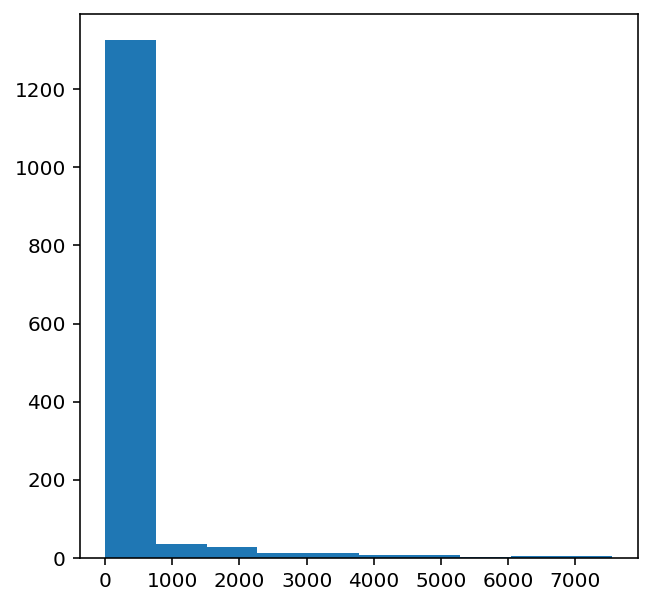

In [9]:
# Notes frequency
freq = dict(Counter(notes_))

no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

## Preparing data

In [10]:
frequent_notes = [note_ for note_, count in freq.items() if count>=frequent_notes_threshold]

# Get the same dataset only with frequent notes
new_music=[]

for notes in notes_array:
    new_music.append([note for note in notes if note in frequent_notes])
    
new_music = np.array(new_music, dtype=object)

In [11]:
inputs = []
outputs = []

for notes_ in new_music:
    for i in range(0, len(notes_) - n_of_timesteps, 1):
        
        inputs.append(notes_[i:i + n_of_timesteps])
        outputs.append(notes_[i + n_of_timesteps])
        
inputs=np.array(inputs)
outputs=np.array(outputs)

In [12]:
unique_inputs = list(set(inputs.ravel()))
input_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_inputs))

input_seq=[]
for input_ in inputs:
    input_seq.append([input_note_to_int[note_] for note_ in input_])
    
input_seq = np.array(input_seq)

In [13]:
unique_outputs = list(set(outputs))
output_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_outputs)) 
output_seq = np.array([output_note_to_int[note_] for note_ in outputs])

## Split data into training and evaluation

In [14]:
input_training, input_validation, output_training, output_validation = train_test_split(input_seq,output_seq,test_size=evaluation_percentage,random_state=0)

## Build model

In [15]:
# LSTM architecture. We will use WaveNet for now
# def lstm():
#   model = Sequential()
#   model.add(LSTM(128,return_sequences=True))
#   model.add(LSTM(128))
#   model.add(Dense(256))
#   model.add(Activation('relu'))
#   model.add(Dense(n_vocab))
#   model.add(Activation('softmax'))
#   model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#   return model

In [16]:
K.clear_session()
model = Sequential()

# Parameters explanation: https://keras.io/api/layers/core_layers/embedding/
model.add(Embedding(len(unique_inputs), output_dimension, input_length=n_of_timesteps,trainable=True)) 

# Parameters explanation: https://keras.io/api/layers/convolution_layers/convolution1d/
model.add(Conv1D(n_of_timesteps*2*2,kernel_size, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(n_of_timesteps*4*2,kernel_size,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(n_of_timesteps*8*2,kernel_size,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())

# Parameters explanation: https://keras.io/api/layers/core_layers/dense/
# 256 -> 512
model.add(Dense(512, activation='relu'))
model.add(Dense(len(unique_outputs), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           32100     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           38528     
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 256)           98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)            0

2021-09-14 11:54:30.480976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fit model

In [17]:
model_name = 'Gwern_big_model_1024.h5'
epochs = 50
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(input_training),np.array(output_training), batch_size=1024, epochs=epochs, validation_data=(np.array(input_validation),np.array(output_validation)),verbose=1, callbacks=[checkpoint])


2021-09-14 11:54:31.160856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
231/231 [==============================] - 768s 3s/step - loss: 4.4072 - val_loss: 4.0863

Epoch 00001: val_loss improved from inf to 4.08634, saving model to Gwern_big_model_1024.h5
Epoch 2/50
231/231 [==============================] - 553s 2s/step - loss: 3.7691 - val_loss: 3.8406

Epoch 00002: val_loss improved from 4.08634 to 3.84056, saving model to Gwern_big_model_1024.h5
Epoch 3/50
231/231 [==============================] - 561s 2s/step - loss: 3.5713 - val_loss: 3.6755

Epoch 00003: val_loss improved from 3.84056 to 3.67550, saving model to Gwern_big_model_1024.h5
Epoch 4/50
231/231 [==============================] - 745s 3s/step - loss: 3.4425 - val_loss: 3.5499

Epoch 00004: val_loss improved from 3.67550 to 3.54987, saving model to Gwern_big_model_1024.h5
Epoch 5/50
231/231 [==============================] - 680s 3s/step - loss: 3.3407 - val_loss: 3.4916

Epoch 00005: val_loss improved from 3.54987 to 3.49165, saving model to Gwern_big_model_1024.h5
Epoch 6/50
231

In [18]:
model = load_model('Gwern_big_model_1024.h5')

## Generate music!

In [26]:
ind = np.random.randint(0,len(input_validation)-1)
print(ind)
random_music = input_validation[ind]
        
predictions=[]
for i in range(len_of_predictions):

    random_music = random_music.reshape(1,n_of_timesteps)

    prob   = model.predict(random_music)[0]
    
    output_pred = np.argmax(prob, axis=0)
    print(output_pred)
    predictions.append(output_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),output_pred)
    random_music = random_music[1:]
    

9118
237
306
306
306
306
306
306
13
306
13
306
306
306
306
306
306
306
306
306
306
13
306
306
306
306
306
306
306
306
306


In [27]:
input_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_inputs)) 
predicted_notes = [input_int_to_note[i] for i in predictions]
print(predicted_notes)

['B-3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'D4', 'G3', 'D4', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'D4', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3', 'G3']


In [28]:
convert_to_midi(predicted_notes, 'gwern_music_small_1024_3.mid')

In [46]:
import math

def beam_search_generator(starting_data, model, len_of_songs, k):
    n_of_timesteps = len(starting_data[0])
    
    # starting k randomly generated states
    indices = np.random.randint(len(starting_data), size=k)
    # [prediction, random_music, score]
    sequences = [[[], starting_data[index], 0.0] for index in indices]
    # walk over each step in sequence

    for _ in range(len_of_songs):
        assert(len(sequences) == k)
        all_candidates = list()
        all_random_music = [sequence[1] for sequence in sequences]
        all_random_music = np.array(all_random_music).reshape(k, n_of_timesteps)
        prob = model.predict(all_random_music)
        # expand each current candidate
        for i in range(k):
            seq, random_music, score = sequences[i]
            for j in range(len(prob[i])):
                assert(len(random_music) == n_of_timesteps)
                new_random_music = np.insert(random_music,len(random_music),j)
                new_random_music = new_random_music[1:]
                candidate = [seq + [j], new_random_music, score - math.log(prob[i][j])]
                all_candidates.append(candidate)

        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[2])
        # select k best
        sequences = ordered[:k]
    return sequences

In [ ]:
# generate music with beam search
result = beam_search_generator(input_validation, model, len_of_predictions, 3)
# print generated songs
for seq in result:
    print(seq)

In [22]:
# print best song generated and save midi
predicted_notes = [input_int_to_note[i] for i in seq[0]]
print(predicted_notes)
convert_to_midi(predicted_notes, 'gwern_music_small_1024_beam_search.mid')

[[6 6 5 6 5 3]]
